# Notebook Imports

In [1]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from PIL import Image
from sklearn.model_selection import train_test_split
from pprint import pprint

from bs4 import BeautifulSoup

%matplotlib inline

# Constants

In [2]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_PATH_1 = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_PATH_2 = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_PATH_1 = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_PATH_2 = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = "SpamData/02_Training/train-data.txt"
TEST_DATA_FILE = "SpamData/02_Training/test-data.txt"

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
BOLD_FONT_FILE_PATH = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'
LIGHT_FONT_FILE_PATH = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Light.ttf'

# Reading Files

In [3]:
stream = open(EXAMPLE_FILE)
msg = stream.read()
stream.close()

print(msg)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [4]:
import sys

sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE)

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

mail_body = str('\n'.join(lines))
print(mail_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [6]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number**2

In [7]:
for i in generate_squares(5):
    print(i, end='-->')

0-->1-->4-->9-->16-->

## Email body extraction 

In [8]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
                    
            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [9]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_PATH_1, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_PATH_2, 1))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_PATH_1, 0)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_PATH_2, 0))
ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [13]:
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is', data.shape)
data.head()

Shape of entire dataframe is (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


# Data Cleaning: Checking for missing values

In [15]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()
# But there are empy 

False

In [16]:
(data.MESSAGE.str.len()==0).sum()

3

In [17]:
data.MESSAGE.isnull().sum()

0

# Locate empty emails

In [18]:
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

# Remove System File Entries from Dataframe

In [19]:
data.drop('cmds', inplace=True)
data.shape

(5796, 2)

# Add document IDs to Track Emails in Dataset

In [20]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids
data

,MESSAGE,CATEGORY,DOC_ID
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,0
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,2
00004.eac8de8d759b7e74154f142194282724,##############################################...,1,3
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1,4
...,...,...,...
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0,5792
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,5794


In [21]:
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


# Save to file using Pandas

In [22]:
data.to_json(DATA_JSON_FILE)

In [23]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [24]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

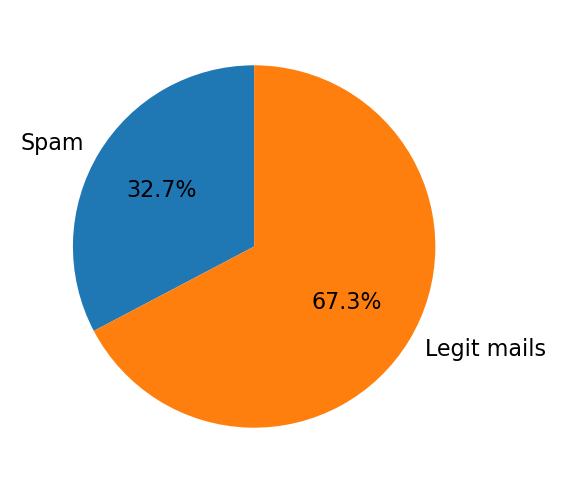

In [25]:
category_names = ['Spam', 'Legit mails']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(3, 3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={'fontsize':8}, startangle=90, autopct='%1.1f%%')
plt.show()

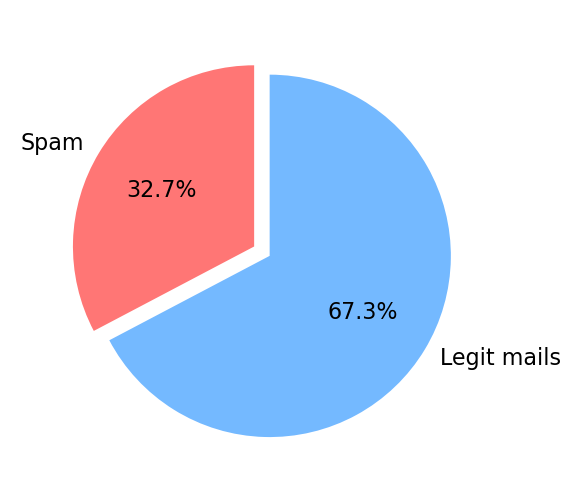

In [26]:
category_names = ['Spam', 'Legit mails']
sizes = [amount_of_spam, amount_of_ham]

custom_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(3, 3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={'fontsize':8}, startangle=90,
        autopct='%1.1f%%', colors=custom_colors, explode=[0, 0.1])
plt.show()

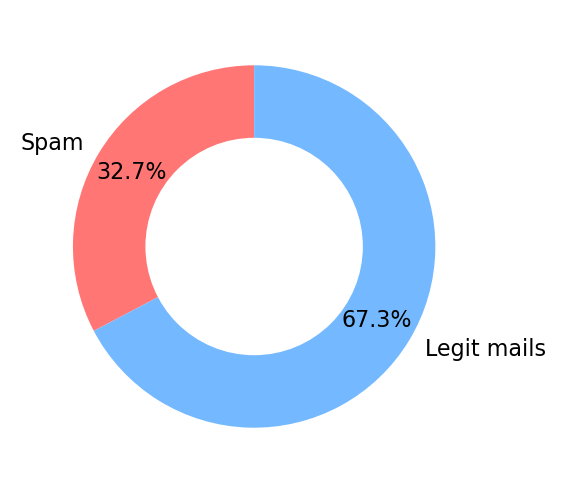

In [27]:
category_names = ['Spam', 'Legit mails']
sizes = [amount_of_spam, amount_of_ham]

custom_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(3, 3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={'fontsize':8}, startangle=90,
        autopct='%1.1f%%', colors=custom_colors, pctdistance=0.79)

center_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)

plt.show()

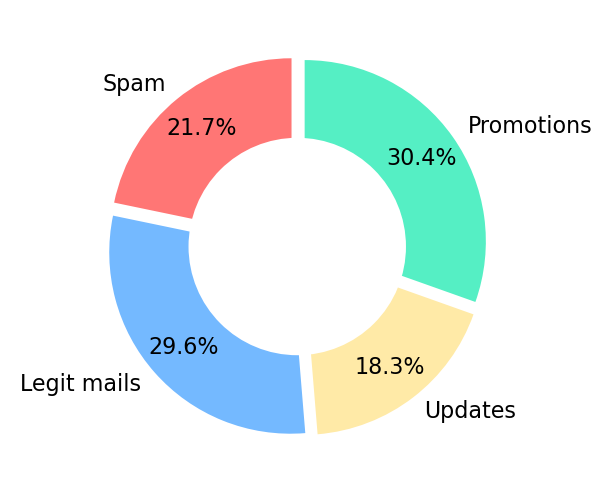

In [28]:
# This code cell is only for the practice #


category_names = ['Spam', 'Legit mails', 'Updates', 'Promotions']
sizes = [25, 34, 21, 35]

custom_colors = ['#ff7675', '#74b9ff', '#ffeaa7', '#55efc4']
offset = [0.05, 0.05 , 0.05, 0.05]

plt.figure(figsize=(3, 3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={'fontsize':8}, startangle=90,
        autopct='%1.1f%%', colors=custom_colors, pctdistance=0.79, explode=offset)

center_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)

plt.show()

# Natural Language Processing

### Text Pre-Processing

In [29]:
msg = 'AlL work and no play makes Jack a dull boy'
msg.lower()

'all work and no play makes jack a dull boy'

## Download the NLTK Resources( Tokenizer & Stopwords)

In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
nltk.download('shakespeare')

[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [33]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

## Tokenizing

In [34]:
msg = 'AlL work and no play makes Jack a dull boy'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

## Removing the Stop-words

In [35]:
stop_words = set(stopwords.words('english'))

In [36]:
type(stop_words)

set

In [37]:
if 'hello' not in stop_words:
    print('Nope, not i here')

Nope, not i here


In [38]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. Nobody expects Spanish In inquisition!'
words = word_tokenize(msg.lower())

filtered_words = []
stemmer = PorterStemmer()

for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
filtered_words

['work',
 'play',
 'make',
 'jack',
 'dull',
 'boy',
 '.',
 '.',
 'nobodi',
 'expect',
 'spanish',
 'inquisit',
 '!']

## Removing Punctuation

In [39]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. Nobody expects Spanish In inquisition!'
words = word_tokenize(msg.lower())

filtered_words = []
stemmer = SnowballStemmer('english')

for word in words:
    if word not in stop_words:
        if word.isalpha() == True:
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
filtered_words

['work',
 'play',
 'make',
 'jack',
 'dull',
 'boy',
 'nobodi',
 'expect',
 'spanish',
 'inquisit']

## Removing HTML tags from emails

In [40]:
soup = BeautifulSoup(data.at[36, 'MESSAGE'], 'html.parser')
print(soup.prettify())

<html>
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="Microsoft FrontPage 4.0" name="GENERATOR"/>
  <meta content="FrontPage.Editor.Document" name="ProgId"/>
  <title>
   New Page 1
  </title>
 </head>
 <body bgcolor="#808080">
  <p align="center">
   <span style="font-family: Arial; mso-fareast-font-family: Times New Roman; mso-ansi-language: EN-US; mso-fareast-language: EN-US; mso-bidi-language: AR-SA">
    <font size="5">
     <span style="font-family: Arial; mso-fareast-font-family: Times New Roman; color: red; mso-ansi-language: EN-US; mso-fareast-language: EN-US; mso-bidi-language: AR-SA">
      VIAGRA
      <br/>
     </span>
     <span style="font-family: Arial; mso-fareast-font-family: Times New Roman; color: black; mso-ansi-language: EN-US; mso-fareast-language: EN-US; mso-bidi-language: AR-SA">
      WITHOUT
      <br/>
      A DOCTORS VISIT!!
     </span>
    </font>
   </span>
  </p>
  <p align="center">
   <a href="http://w

In [41]:
soup.get_text()

'\n\n\n\n\nNew Page 1\n\n\nVIAGRA\nWITHOUT\n\nA DOCTORS VISIT!!\nCLICK\n\nHERE\n*Other\n\nTop Medications also available!!\n\n\n*We\n\nhave Doctors on call around the country to view\n\nyour information and quickly approve your order.\n\n\n*Totally\n\nDiscreet System allows you to order today and\n\nenjoy your medication tomorrow in most cases.\n\n\n*Finally\n\nyou can try the wonder drug Viagra that\n\nhas swept the World without the embarrassment of\n\nhaving to visit your Doctor and explain your condition!!\nTO\n\nORDER CLICK HERE!\n\xa0\n\xa0\n\xa0\n\xa0\n\xa0\n\xa0\n\xa0\n\xa0\nTO GET DELETED \nhttp://194.44.46.21/remove.php\n\xa0\n\xa0\n\n\n\n3606uLdz7-798Gxne6717WLiQ1-104VoKJ8349uvAE9-31l43\n\n\n'

## Functions for email processing

In [42]:
def clean_message(message, stemmer=PorterStemmer(), stop_words = set(stopwords.words('english'))):
    
    words = word_tokenize(message.lower())
    
    filtered_words = []
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words   

In [43]:
clean_message(data.at[36, 'MESSAGE'])

['html',
 'head',
 'meta',
 'meta',
 'gener',
 'microsoft',
 'frontpag',
 'meta',
 'progid',
 'titl',
 'new',
 'page',
 'bodi',
 'p',
 'center',
 'span',
 'arial',
 'time',
 'new',
 'roman',
 'font',
 'span',
 'arial',
 'time',
 'new',
 'roman',
 'color',
 'red',
 'viagra',
 'br',
 'span',
 'arial',
 'time',
 'new',
 'roman',
 'color',
 'black',
 'without',
 'br',
 'doctor',
 'visit',
 'p',
 'center',
 'http',
 'font',
 'click',
 'br',
 'p',
 'center',
 'center',
 'span',
 'arial',
 'span',
 'arial',
 'font',
 'top',
 'medic',
 'also',
 'avail',
 'p',
 'p',
 'p',
 'center',
 'center',
 'span',
 'arial',
 'font',
 'doctor',
 'call',
 'around',
 'countri',
 'view',
 'br',
 'inform',
 'quickli',
 'approv',
 'p',
 'p',
 'p',
 'center',
 'center',
 'span',
 'arial',
 'font',
 'total',
 'discreet',
 'system',
 'allow',
 'order',
 'today',
 'br',
 'enjoy',
 'medic',
 'tomorrow',
 'p',
 'p',
 'p',
 'center',
 'span',
 'arial',
 'time',
 'new',
 'roman',
 'font',
 'final',
 'tri',
 'wonder',
 '

In [44]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), stop_words = set(stopwords.words('english'))):
    
    soup = BeautifulSoup(message, 'html.parser')
    tagless_msg = soup.get_text()
    words = word_tokenize(tagless_msg.lower())
    
    filtered_words = []
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words   

In [45]:
clean_msg_no_html(data.at[36, 'MESSAGE'])

['new',
 'page',
 'viagra',
 'without',
 'doctor',
 'visit',
 'click',
 'top',
 'medic',
 'also',
 'avail',
 'doctor',
 'call',
 'around',
 'countri',
 'view',
 'inform',
 'quickli',
 'approv',
 'order',
 'total',
 'discreet',
 'system',
 'allow',
 'order',
 'today',
 'enjoy',
 'medic',
 'tomorrow',
 'case',
 'final',
 'tri',
 'wonder',
 'drug',
 'viagra',
 'swept',
 'world',
 'without',
 'embarrass',
 'visit',
 'doctor',
 'explain',
 'condit',
 'order',
 'click',
 'get',
 'delet',
 'http']

In [46]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_message)

In [47]:
flat_list = []
for sublist in nested_list:
    for item in sublist:
        flat_list.append(item)
        
len(flat_list)
flat_list

['doctyp',
 'html',
 'public',
 'html',
 'html',
 'head',
 'meta',
 'ype',
 'meta',
 'mshtml',
 'bodi',
 'insert',
 'calypso',
 'tabl',
 'color',
 'black',
 'display',
 'none',
 'tbodi',
 'tr',
 'td',
 'hr',
 'noshad',
 'tr',
 'td',
 'hr',
 'noshad',
 'end',
 'calypso',
 'insert',
 'font',
 'arial',
 'helvetica',
 'br',
 'end',
 'calypso',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'save',
 'life',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'spend',
 'center',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'life',
 'quot',
 'save',
 'center',
 'p',
 'p',
 'br',
 'p',
 'center',
 'tabl',
 'tbodi',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'b',
 'font',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'tr',
 'td',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'font',
 'b',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',

In [48]:
%%time
# use apply an all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\DELL\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 38.5 s


In [49]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

## Using Logic to Slice Dataframes 

In [50]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [51]:
data[data.CATEGORY == 1].tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1891,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",1,01396.e80a10644810bc2ae3c1b58c5fd38dfa
1892,This is a multi-part message in MIME format.\n...,1,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1893,"Dear Subscriber,\n\n\n\nIf I could show you a ...",1,01398.8ca7045aae4184d56e8509dc5ad6d979
1894,****Mid-Summer Customer Appreciation SALE!****...,1,01399.2319643317e2c5193d574e40a71809c2
1895,ATTN:SIR/MADAN \n\n\n\n ...,1,01400.b444b69845db2fa0a4693ca04e6ac5c5


In [52]:
doc_ids_spam = data.index[data.CATEGORY == 1]
doc_ids_ham = data.index[data.CATEGORY == 0]
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [53]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [54]:
type(nested_list)

pandas.core.series.Series

In [55]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, Length: 1896, dtype: object

In [56]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham

DOC_ID
1896    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1897    [martin, post, tasso, papadopoulo, greek, scul...
1898    [man, threaten, explos, moscow, thursday, augu...
1899    [klez, viru, wo, die, alreadi, prolif, viru, e...
1900    [ad, cream, spaghetti, carbonara, effect, past...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 3900, dtype: object

In [57]:
spam_list_words = [words for lists in nested_list_spam for words in lists]
spam_words = pd.Series(spam_list_words).value_counts()
spam_words.count()

13242

In [58]:
spam_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

In [59]:
ham_list_words = [words for lists in nested_list_ham for words in lists]
normal_words = pd.Series(ham_list_words).value_counts()
normal_words.count()

20815

In [60]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [61]:
common_words = list(set(spam_words).intersection(normal_words))
len(common_words)

299

## Creating a Word Cloud

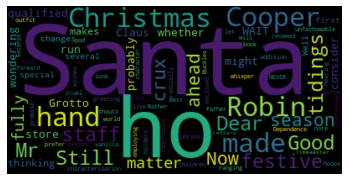

In [62]:
word_cloud = WordCloud().generate(mail_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [63]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [64]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [65]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [66]:
word_list = [''.join(word) for word in example_corpus]
word_list

['[',
 'Moby',
 'Dick',
 'by',
 'Herman',
 'Melville',
 '1851',
 ']',
 'ETYMOLOGY',
 '.',
 '(',
 'Supplied',
 'by',
 'a',
 'Late',
 'Consumptive',
 'Usher',
 'to',
 'a',
 'Grammar',
 'School',
 ')',
 'The',
 'pale',
 'Usher',
 '--',
 'threadbare',
 'in',
 'coat',
 ',',
 'heart',
 ',',
 'body',
 ',',
 'and',
 'brain',
 ';',
 'I',
 'see',
 'him',
 'now',
 '.',
 'He',
 'was',
 'ever',
 'dusting',
 'his',
 'old',
 'lexicons',
 'and',
 'grammars',
 ',',
 'with',
 'a',
 'queer',
 'handkerchief',
 ',',
 'mockingly',
 'embellished',
 'with',
 'all',
 'the',
 'gay',
 'flags',
 'of',
 'all',
 'the',
 'known',
 'nations',
 'of',
 'the',
 'world',
 '.',
 'He',
 'loved',
 'to',
 'dust',
 'his',
 'old',
 'grammars',
 ';',
 'it',
 'somehow',
 'mildly',
 'reminded',
 'him',
 'of',
 'his',
 'mortality',
 '.',
 '"',
 'While',
 'you',
 'take',
 'in',
 'hand',
 'to',
 'school',
 'others',
 ',',
 'and',
 'to',
 'teach',
 'them',
 'by',
 'what',
 'name',
 'a',
 'whale',
 '-',
 'fish',
 'is',
 'to',
 'be',
 

In [67]:
novel_as_string = ' '.join(word_list)
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

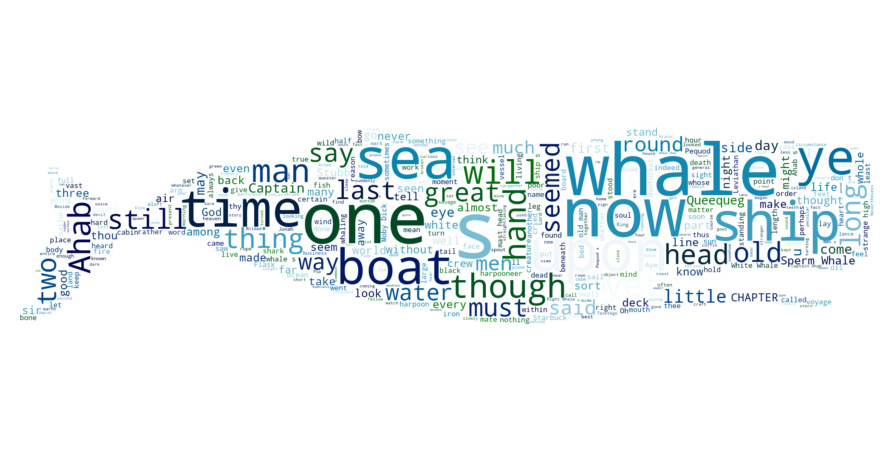

In [68]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)


word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=400, colormap='ocean').generate(novel_as_string)
plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [69]:
rgb_array.shape

(1024, 2048, 3)

In [70]:
example_corpus_2 = nltk.corpus.shakespeare.words('hamlet.xml')
len(example_corpus_2)

40379

In [71]:
word_list = [''.join(word) for word in example_corpus_2]
word_list

['The',
 'Tragedy',
 'of',
 'Hamlet',
 ',',
 'Prince',
 'of',
 'Denmark',
 'Dramatis',
 'Personae',
 'CLAUDIUS',
 ',',
 'king',
 'of',
 'Denmark',
 '.',
 'HAMLET',
 ',',
 'son',
 'to',
 'the',
 'late',
 ',',
 'and',
 'nephew',
 'to',
 'the',
 'present',
 'king',
 '.',
 'POLONIUS',
 ',',
 'lord',
 'chamberlain',
 '.',
 'HORATIO',
 ',',
 'friend',
 'to',
 'Hamlet',
 '.',
 'LAERTES',
 ',',
 'son',
 'to',
 'Polonius',
 '.',
 'LUCIANUS',
 ',',
 'nephew',
 'to',
 'the',
 'king',
 '.',
 'VOLTIMAND',
 'CORNELIUS',
 'ROSENCRANTZ',
 'GUILDENSTERN',
 'OSRIC',
 'courtiers',
 '.',
 'A',
 'Gentleman',
 'A',
 'Priest',
 '.',
 'MARCELLUS',
 'BERNARDO',
 'officers',
 '.',
 'FRANCISCO',
 ',',
 'a',
 'soldier',
 '.',
 'REYNALDO',
 ',',
 'servant',
 'to',
 'Polonius',
 '.',
 'Players',
 '.',
 'Two',
 'Clowns',
 ',',
 'grave',
 '-',
 'diggers',
 '.',
 'FORTINBRAS',
 ',',
 'prince',
 'of',
 'Norway',
 '.',
 'A',
 'Captain',
 '.',
 'English',
 'Ambassadors',
 '.',
 'GERTRUDE',
 ',',
 'queen',
 'of',
 'Denmar

In [72]:
novel_as_string = ' '.join(word_list)
novel_as_string

"The Tragedy of Hamlet , Prince of Denmark Dramatis Personae CLAUDIUS , king of Denmark . HAMLET , son to the late , and nephew to the present king . POLONIUS , lord chamberlain . HORATIO , friend to Hamlet . LAERTES , son to Polonius . LUCIANUS , nephew to the king . VOLTIMAND CORNELIUS ROSENCRANTZ GUILDENSTERN OSRIC courtiers . A Gentleman A Priest . MARCELLUS BERNARDO officers . FRANCISCO , a soldier . REYNALDO , servant to Polonius . Players . Two Clowns , grave - diggers . FORTINBRAS , prince of Norway . A Captain . English Ambassadors . GERTRUDE , queen of Denmark , and mother to Hamlet . OPHELIA , daughter to Polonius . Lords , Ladies , Officers , Soldiers , Sailors , Messengers , and other Attendants . Ghost of Hamlet ' s Father . SCENE Denmark . HAMLET ACT I SCENE I . Elsinore . A platform before the castle . FRANCISCO at his post . Enter to him BERNARDO BERNARDO Who ' s there ? FRANCISCO Nay , answer me : stand , and unfold yourself . BERNARDO Long live the king ! FRANCISCO B

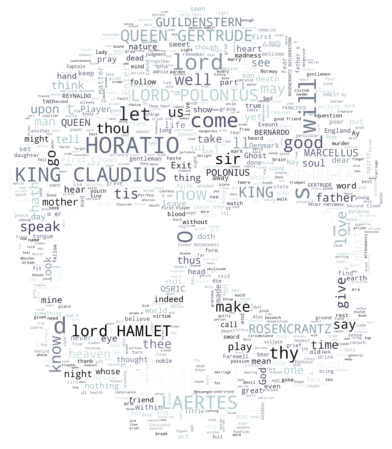

In [73]:
icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)


word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=800, colormap='bone').generate(novel_as_string)
plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# WordCloud of Ham and Spam Messages

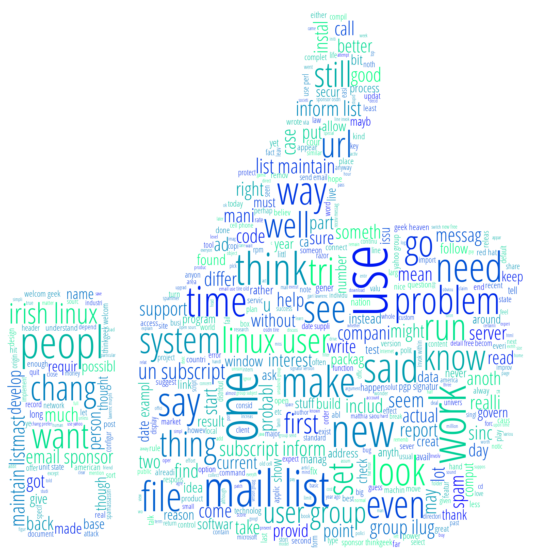

In [74]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)
ham_str = ' '.join(ham_list_words)

word_cloud = WordCloud(font_path=LIGHT_FONT_FILE_PATH, mask=rgb_array, background_color='white',
                       max_words=500, colormap='winter').generate(ham_str)
plt.figure(figsize=(20, 10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

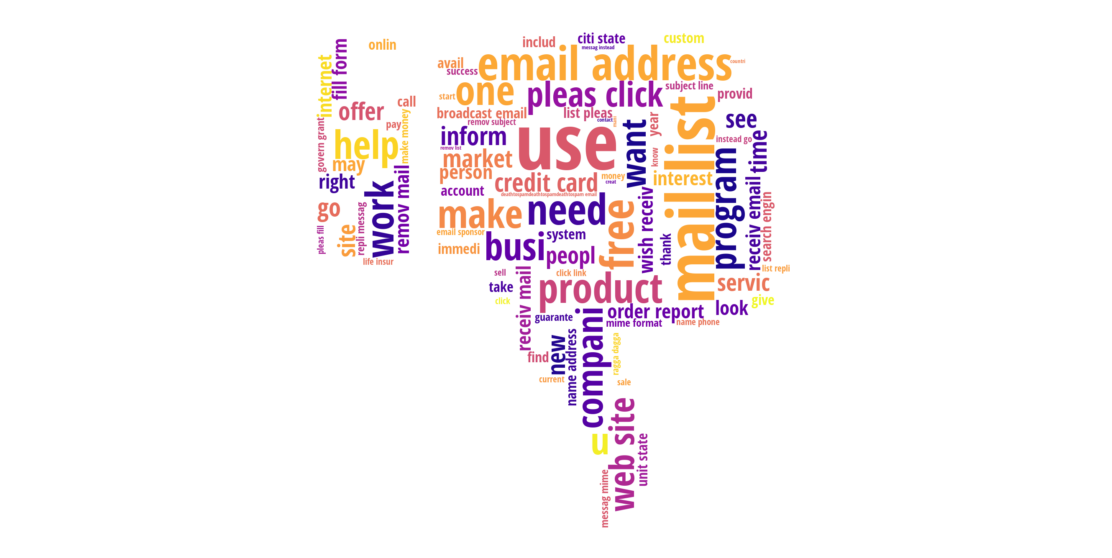

In [75]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)
spam_str = ' '.join(spam_list_words)

word_cloud = WordCloud(font_path=BOLD_FONT_FILE_PATH, mask=rgb_array, background_color='white',
                       max_words=600, colormap='plasma').generate(spam_str)
plt.figure(figsize=(20, 10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [76]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]
len(flat_stemmed_list)

C:\Users\DELL\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


759578

In [77]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words: ', len(unique_words))

Number of unique words:  27334


In [78]:
frequent_words = unique_words[:VOCAB_SIZE]
frequent_words[:10]

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64

# Creating Vocabulary Dataframe with a Word_ID

In [79]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head(5)

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV file

In [80]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header = vocab.VOCAB_WORD.name)

In [81]:
TRIAL_WORD = 'learn'
dict_read = pd.read_csv(WORD_ID_FILE)
if TRIAL_WORD in dict_read['VOCAB_WORD'].values:
    print('TRUE')
else:
    print('False')

TRUE


In [82]:
TRIAL_WORD in set(vocab.VOCAB_WORD)

True

In [83]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
mail_lengths = [len(sublist) for sublist in stemmed_nested_list]
max(mail_lengths)

C:\Users\DELL\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


7671

In [84]:
max_words = max(mail_lengths)
mail_lengths.index(max_words)

5775

In [85]:
stemmed_nested_list[5775]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [86]:
data.at[5775, 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & Sparse Matrix

### Creating a Dataframe with one word per column

In [87]:
stemmed_nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [88]:
type(stemmed_nested_list)

pandas.core.series.Series

In [89]:
type(stemmed_nested_list.tolist())

list

In [90]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5791,http,bizarr,collect,stuf,anim,could,fetch,sold,cornwal,museum,...,None,None,None,None,None,None,None,None,None,None
5792,care,use,one,also,realli,cute,thing,japanes,av,girl,...,None,None,None,None,None,None,None,None,None,None
5793,sm,skip,montanaro,write,jeremi,put,anoth,way,interest,hear,...,None,None,None,None,None,None,None,None,None,None
5794,mark,hammond,like,given,zodb,sound,attract,would,packag,hundr,...,None,None,None,None,None,None,None,None,None,None


In [91]:
word_columns_df.shape

(5796, 7671)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data['CATEGORY'], random_state=42, test_size=0.3)

In [93]:
print('Nr of training samples:', X_train.shape[0])
print('Nr of testing samples:', X_test.shape[0])

Nr of training samples: 4057
Nr of testing samples: 1739


In [94]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [95]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [96]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for training Dataset

In [97]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'potent', 'maxaman', 'pci', 'fashion', 'advisor', 'shoot', 'combat',
       'manner', 'distinct', 'occasion'],
      dtype='object', name='VOCAB_WORD', length=2500)

In [98]:
word_index.get_loc('thu')

392

In [99]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Return sparse matrix as dataframe
    
    df: A dataframe with words in column and document ids as an index (X_train or X_test)
    indexed_words: index of words ordered by word_id
    labels: category as a series (y_train, y_test) 
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                items = {'LABEL': category, 'WORD_ID': word_id, 'OCCURANCE': 1, 'DOC_ID': doc_id}
                dict_list.append(items)
            
    return pd.DataFrame(dict_list)

In [102]:
#%%time
#sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 18min 15s


In [103]:
sparse_train_df.shape

(429243, 4)

### Combine Occurances with Pandas groupby() method

In [104]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURANCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [105]:
vocab.at[7, 'VOCAB_WORD']

'free'

In [106]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [107]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURANCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [108]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURANCE
258377,5795,2032,0,1
258378,5795,2033,0,2
258379,5795,2268,0,1
258380,5795,2334,0,1
258381,5795,2369,0,1


In [109]:
vocab.at[2040,'VOCAB_WORD']

'farmer'

In [110]:
pprint(data.MESSAGE[5795])

('Hi there,\n'
 '\n'
 '\n'
 '\n'
 'Now this is probably of no use to you whatsoever, but...\n'
 '\n'
 '\n'
 '\n'
 "Not a deb-head, but I also have a problem regards NVidia. I've two "
 'machines,\n'
 '\n'
 'pretty much the same hardware. \n'
 '\n'
 "athlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n"
 '\n'
 'both use the same driver module. \n'
 '\n'
 '\n'
 '\n'
 'Both have same kernel version albeit it compiled for their particular\n'
 '\n'
 'hardware.\n'
 '\n'
 '\n'
 '\n'
 'One works perfectly, the other fails to load. When I check with lsmod, I '
 'can\n'
 '\n'
 'see the NVdriver is loaded, but not used ;--(\n'
 '\n'
 'Thus when I startx, it bombs out. \n'
 '\n'
 '\n'
 '\n'
 'IU still have X with the default nv driver and crappy accelleration -->\n'
 '\n'
 '650fps with glxgears [should be over 2000fps]\n'
 '\n'
 'Its not a hardware issue with the cards as I swapped them over and get the\n'
 '\n'
 'same symptoms. \n'
 '\n'
 '\n'
 '\n'
 "I reckon my mobo is cac

In [111]:
train_grouped.shape

(258382, 4)

In [ ]:
#np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [112]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURANCE'], dtype='object')

### Creating Sparse matrix for testing dataset 

In [ ]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

In [ ]:
sparse_test_df.shape

In [ ]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
test_grouped.head()

In [ ]:
vocab.VOCAB_WORD.at[3]

In [ ]:
pprint(data.MESSAGE[8])

In [ ]:
test_grouped = test_grouped.reset_index()
test_grouped.head()

In [ ]:
test_grouped.shape

In [ ]:
#np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')